#  Automatic Liver Segmentation Using Deep Learning
---
---
### Medical Image Analysis with U-Net Architecture

---

## 📌 Project Overview

This project focuses on **automatic liver segmentation** from medical images (e.g., CT or MRI scans) using **deep learning**, specifically the **U-Net architecture**. The goal is to accurately isolate the liver region from volumetric image data, which is a crucial preprocessing step in many medical analysis and diagnostic pipelines.

---

## 📂 Dataset

- **Source:** Kaggle
- **Shape:** `(512, 512, 1)`
- **Contents:** 
  - **Images:** Liver CT images
  - **Labels:** Corresponding binary masks (1 = liver, 0 = background)

> Ensure the dataset is preprocessed and normalized before training (e.g., resizing, slicing, intensity normalization).

---

## 🏗️ Model Architecture

### 🔬 U-Net

The U-Net is a convolutional neural network designed for biomedical image segmentation.

#### Key Components:
- **Encoder (Contracting Path):** Feature extraction via stacked Conv + MaxPooling
- **Bottleneck:** Bridge between encoder and decoder
- **Decoder (Expanding Path):** Upsampling + skip connections for precise localization
- **Skip Connections:** Allow high-resolution features to flow to deeper layers

> U-Net is especially effective with small training datasets, using data augmentation and symmetric architecture.

---

## 🧪 Preprocessing Pipeline

1. Load images and masks of liver dataset
2. Normalize pixel values (0-1 )
3. Resize slices to a consistent shape (e.g., 256x256)
4. Split into train/val/test sets
5. Create a zip file of images and masks
---

## 🏋️‍♂️ Training Details

- **Loss Function:** Binary Cross-Entropy
- **Optimizer:** Adam
- **Learning Rate:** `1e-4`
- **Batch Size:** 8–16
- **Epochs:** 10
- **Evaluation Metrics:** Dice Coefficient, IoU, Accuracy

---

## 📈 Results

- **Visual Results:** Predicted masks closely follow ground truth annotations
- **Generalization:** Good performance on unseen test slices

---

## 📊 Visualization

- Overlay masks on input slices
- Show comparison between predicted and ground truth masks
- Plot loss over epochs

---

## 🧠 Future Work

- Incorporate attention mechanisms (Attention U-Net)
- Use multi-organ segmentation for liver + surrounding structures
- Deploy as a medical tool with a simple interface

---

## 📚 References

- **U-Net Paper:** [Ronneberger et al., 2015](https://arxiv.org/abs/1505.0459)
- **Dataset:** [Kaggle Liver Tumor Segmentation Challenge](https://www.kaggle.com/datasets/priyamsaha17/segmentation-of-liver)
- **TensorFlow/Keras** for model development

---


- ###  Import Required Libraries 
----

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers,metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

import cv2 as cv
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import os
import warnings
warnings.filterwarnings('ignore')

- ### Set Images and Masks Path
- ---

In [12]:
img_path='archive/images/images'
mask_path='archive/liver_masks/liver_masks'

- ### Visualizing Images
- ---

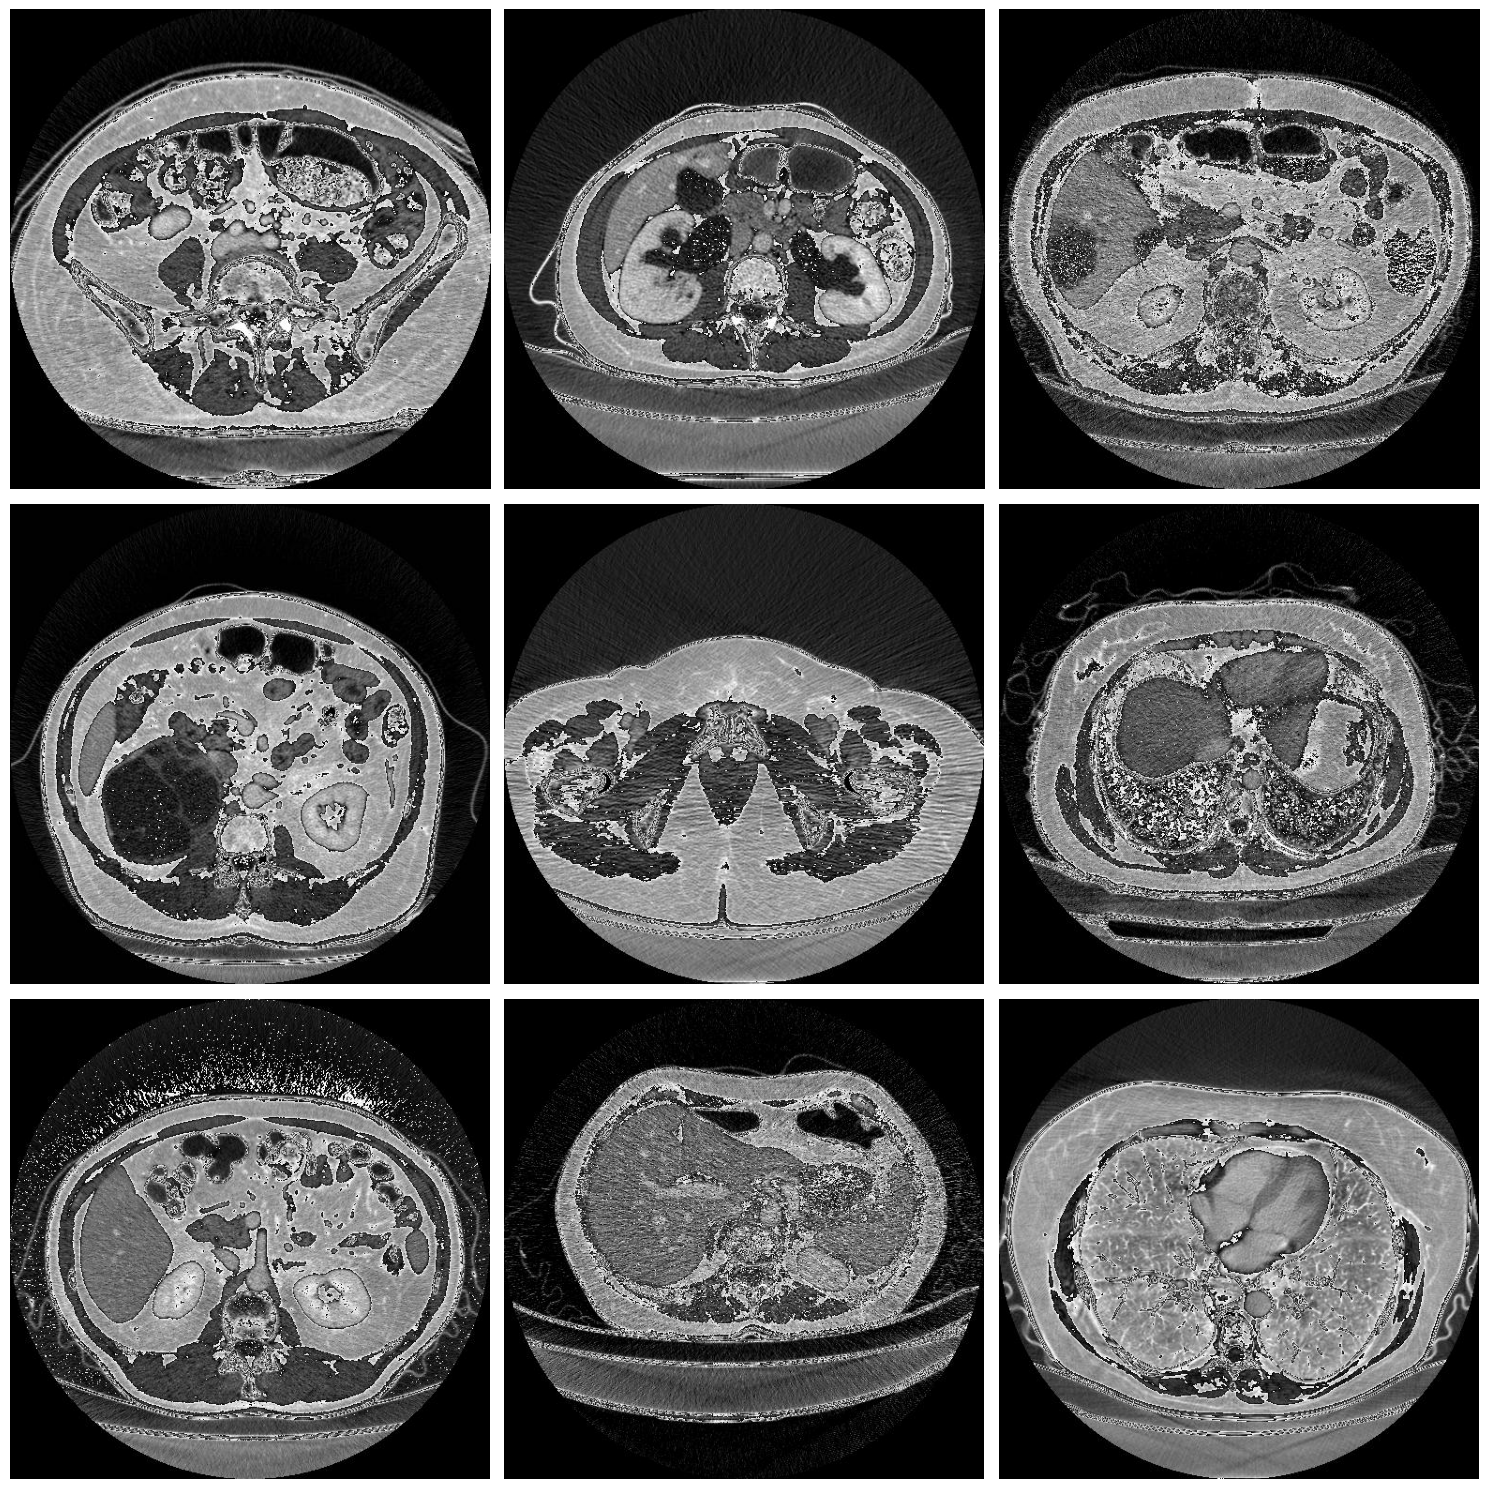

In [13]:
image_files=[file for file in os.listdir(img_path) if file.endswith('.jpg')]
image_to_visualize=image_files[:9]

plt.figure(figsize=(15,15))

for i,img in enumerate(image_to_visualize,1):
    img=cv.imread(os.path.join(img_path,img))
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()

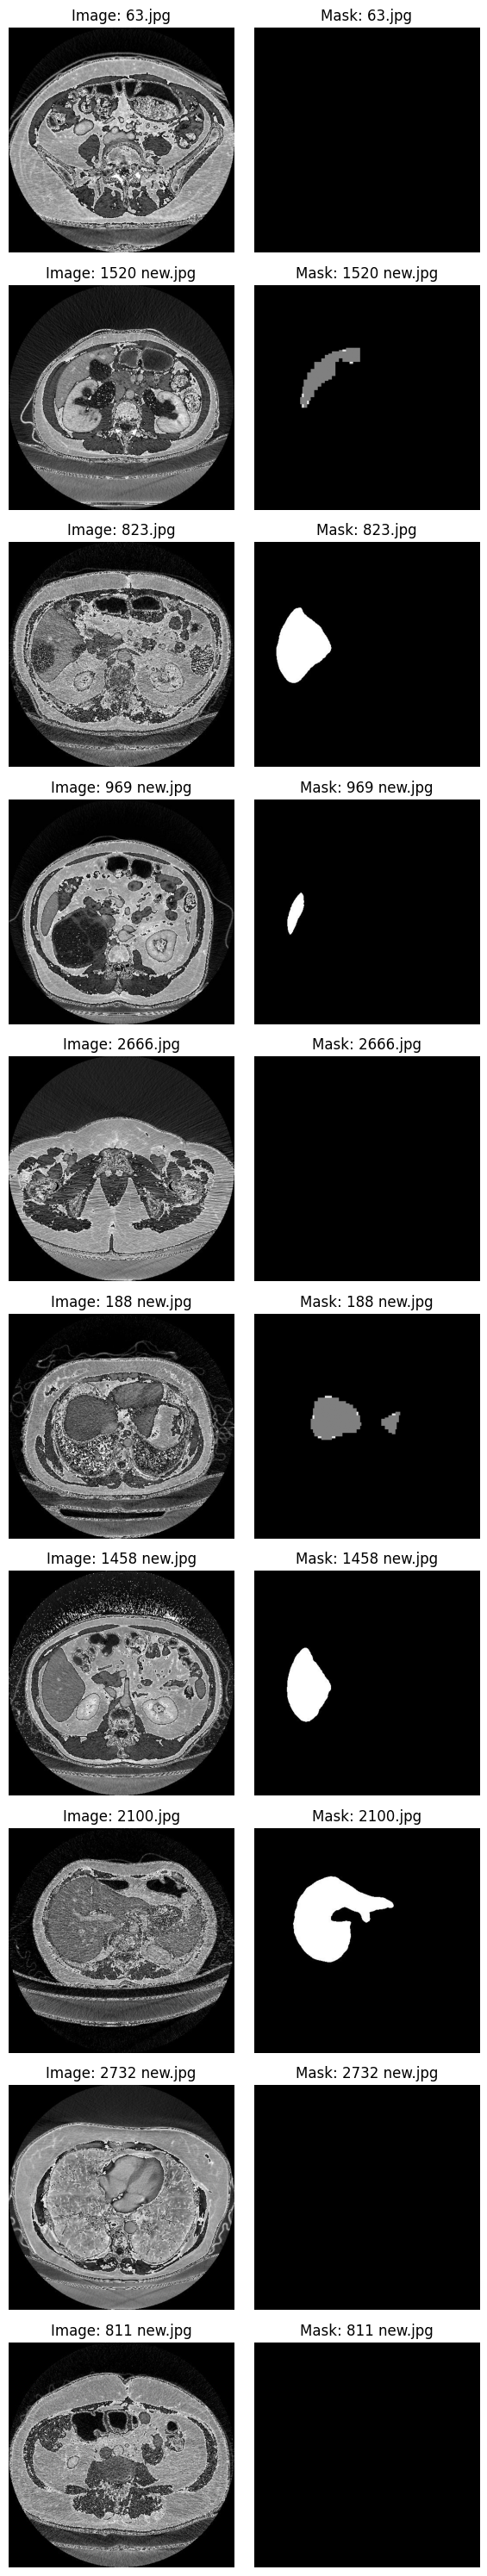

In [14]:
image_files=[file for file in os.listdir(img_path) if file.endswith('.jpg')]
image_to_visualize=image_files[:10]
mask_files=[file for file in os.listdir(mask_path) if file.endswith('.jpg')]

plt.figure(figsize=(6,30))
for i,img_file in enumerate(image_to_visualize):
    img = cv.imread(os.path.join(img_path, img_file))  
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  #
    
    mask = cv.imread(os.path.join(mask_path, img_file), cv.IMREAD_GRAYSCALE) 
    
    
    # Display the image
    plt.subplot(len(image_to_visualize), 2, i * 2 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {img_file}")

    # Display the corresponding mask
    plt.subplot(len(image_to_visualize), 2, i * 2 + 2)
    plt.imshow(mask, cmap='gray')  # Use grayscale for masks
    plt.axis('off')
    plt.title(f"Mask: {img_file}")

plt.tight_layout()

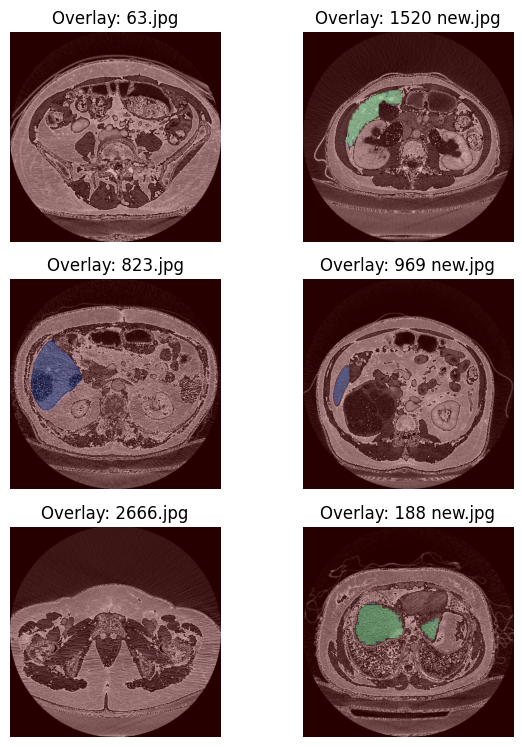

In [15]:
image_files = [file for file in os.listdir(img_path) if file.endswith('.jpg')]


subset_files = image_files[:6]  

# Plot the images with overlays
plt.figure(figsize=(6, 15))

for i, img_file in enumerate(subset_files):
    # Load the image
    img = cv.imread(os.path.join(img_path, img_file))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  
    mask = cv.imread(os.path.join(mask_path, img_file), cv.IMREAD_GRAYSCALE)
    mask_normalized = cv.normalize(mask, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    mask_rgb = cv.applyColorMap(mask_normalized, cv.COLORMAP_JET)  # Apply colormap for better visualization
    overlay = cv.addWeighted(img, 0.7, mask_rgb, 0.3, 0)  # Adjust the weights as needed

    # Display 
    plt.subplot(len(subset_files), 2, i + 1)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"Overlay: {img_file}")

plt.tight_layout()
plt.show()

- ### Split Dataset into Train and Validation
- ----

In [16]:
train_imgs,val_imgs,train_masks,val_masks=train_test_split(image_files,mask_files,test_size=0.2,random_state=42)
len(train_imgs),len(val_imgs)

(4516, 1130)

- ###  Pre-processing
---

In [17]:
import os
import numpy as np
import cv2 as cv
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, img_list, mask_list, img_dir, mask_dir, batch_size=32, target_size=(128, 128)):
        self.img_list = img_list
        self.mask_list = mask_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.img_list) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_imgs = self.img_list[start:end]
        batch_masks = self.mask_list[start:end]
        images = []
        masks = []

        for img_file, mask_file in zip(batch_imgs, batch_masks):
            # Load and preprocess mask
            mask_path = os.path.join(self.mask_dir, mask_file)
            mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
            mask = cv.resize(mask, self.target_size)
            mask = np.expand_dims(mask, axis=-1)
            mask = mask / 255.0
            mask = (mask > 0.5).astype('float32')

            # Skip if mask is blank
            if np.sum(mask) == 0:
                continue  # Skip this pair

            # Load and preprocess image
            img_path = os.path.join(self.img_dir, img_file)
            img = cv.imread(img_path)
            img = cv.resize(img, self.target_size)
            img = img / 255.0  # Normalize to [0, 1]

            images.append(img)
            masks.append(mask)

        # If all masks in the batch were blank and skipped, avoid empty return
        if len(images) == 0:
            # Optionally, you can handle this case, for example by returning a dummy data
            return self.__getitem__((index + 1) % self.__len__())  # get next batch

        return np.array(images), np.array(masks)

- ### Generate Data Pipeline
----

In [18]:
batch_size = 32
target_size = (128, 128)

train_gen = DataGenerator(train_imgs, train_masks, img_path, mask_path, batch_size, target_size)
val_gen = DataGenerator(val_imgs, val_masks, img_path, mask_path, batch_size, target_size)

## Build U-NET Architecture 
-----

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,
                                     BatchNormalization, Dropout, LeakyReLU)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotUniform

def optimized_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    initializer = GlorotUniform()
    regularizer = l2(1e-4)  # L2 regularization
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(pool1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(pool2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.4)(conv3)  # Higher Dropout to reduce overfitting
    conv3 = Conv2D(256, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    
    # Decoder
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer=initializer)(conv3)
    merge4 = concatenate([up4, conv2])
    conv4 = Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(merge4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.3)(conv4)  # Adding Dropout in decoder layers
    conv4 = Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    conv4 = BatchNormalization()(conv4)
    
    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer=initializer)(conv4)
    merge5 = concatenate([up5, conv1])
    conv5 = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(merge5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = BatchNormalization()(conv5)
    
    # Output Layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    
    model = Model(inputs, output)
    return model

- ### Define Loss 
----

In [20]:
import tensorflow.keras.backend as K 

def dice_coefficient(y_true, y_pred):
    """Calculate the Dice Coefficient."""
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

def iou(y_true, y_pred):
    """Calculate the Intersection over Union (IoU)."""
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

- ## Compile Model
- --- 

In [21]:
model=optimized_unet()
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, iou])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_4[0][0]  

 Total params: 1,867,969 (7.13 MB)

 Trainable params: 1,865,409 (7.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

- ### Model Training
- ---

In [22]:
validation_steps = len(val_gen) if len(val_gen) % batch_size == 0 else len(val_gen) // batch_size + 1
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
)

Epoch 1/20


2025-05-21 17:37:25.042481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 311ms/step - accuracy: 0.8519 - dice_coefficient: 0.3014 - iou: 0.1829 - loss: 0.5473 - val_accuracy: 0.0754 - val_dice_coefficient: 0.1371 - val_iou: 0.0738 - val_loss: 157.2594
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - accuracy: 0.9726 - dice_coefficient: 0.6118 - iou: 0.4463 - loss: 0.1924 - val_accuracy: 0.0940 - val_dice_coefficient: 0.1396 - val_iou: 0.0752 - val_loss: 76.6786
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.9757 - dice_coefficient: 0.7055 - iou: 0.5498 - loss: 0.1459 - val_accuracy: 0.5139 - val_dice_coefficient: 0.2337 - val_iou: 0.1328 - val_loss: 10.6753
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 33s 235ms/step - accuracy: 0.9822 - dice_coefficient: 0.7918 - iou: 0.6573 - loss: 0.1109 - val_accuracy: 0.8420 - val_dice_coefficient: 0.4370 - val_iou: 0.2814 - val_loss: 1.0292
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 34s 237ms/step - accuracy: 0.9860 - dice_coefficient: 0.8409 - iou: 0.7275 - loss: 

In [23]:
model.save('liver_segmentation_model_final.keras')

In [24]:
val_loss, val_accuracy, val_dice, val_iou = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Dice Coefficient: {val_dice:.4f}")
print(f"Validation IoU: {val_iou:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9918 - dice_coefficient: 0.8867 - iou: 0.7968 - loss: 0.0436
Validation Loss: 0.0437
Validation Accuracy: 0.9918
Validation Dice Coefficient: 0.8850
Validation IoU: 0.7941


## Model Evaluation and Plotting Predicitons
-----

In [3]:
for i in range(5):  # Visualize 5 samples
    img, true_mask = val_gen[i]
    pred_mask = model.predict(img)
    pred_mask = (pred_mask > 0.5).astype(np.float32)  # Apply thresholding

    # Calculate metrics for this sample
    dice = dice_coefficient(true_mask, pred_mask).numpy()
    intersection = np.sum(true_mask * pred_mask)
    union = np.sum(true_mask) + np.sum(pred_mask) - intersection
    iou_value = intersection / (union + 1e-7)

    # Plot the results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0])
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[0].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[0].squeeze(), cmap='gray')
    plt.title(f"Predicted Mask\nDice: {dice:.4f}, IoU: {iou_value:.4f}")
    plt.axis("off")

    plt.show()

NameError: name 'val_gen' is not defined

In [26]:
liver_history = pd.DataFrame(history.history)

In [27]:
liver_history.head()

accuracy  dice_coefficient       iou      loss  val_accuracy  \
0  0.932680          0.398224  0.256133  0.377107      0.075439   
1  0.975305          0.660314  0.498461  0.169244      0.093980   
2  0.974265          0.698834  0.541361  0.147236      0.513871   
3  0.982531          0.799399  0.668294  0.105912      0.842003   
4  0.983217          0.832109  0.721444  0.104672      0.193919   

   val_dice_coefficient   val_iou    val_loss  
0              0.137103  0.073774  157.259399  
1              0.139634  0.075241   76.678650  
2              0.233701  0.132845   10.675252  
3              0.437000  0.281374    1.029210  
4              0.144620  0.078167   90.324593

In [28]:
liver_history = liver_history.reset_index(drop=True)
liver_history['epoch'] = liver_history.index

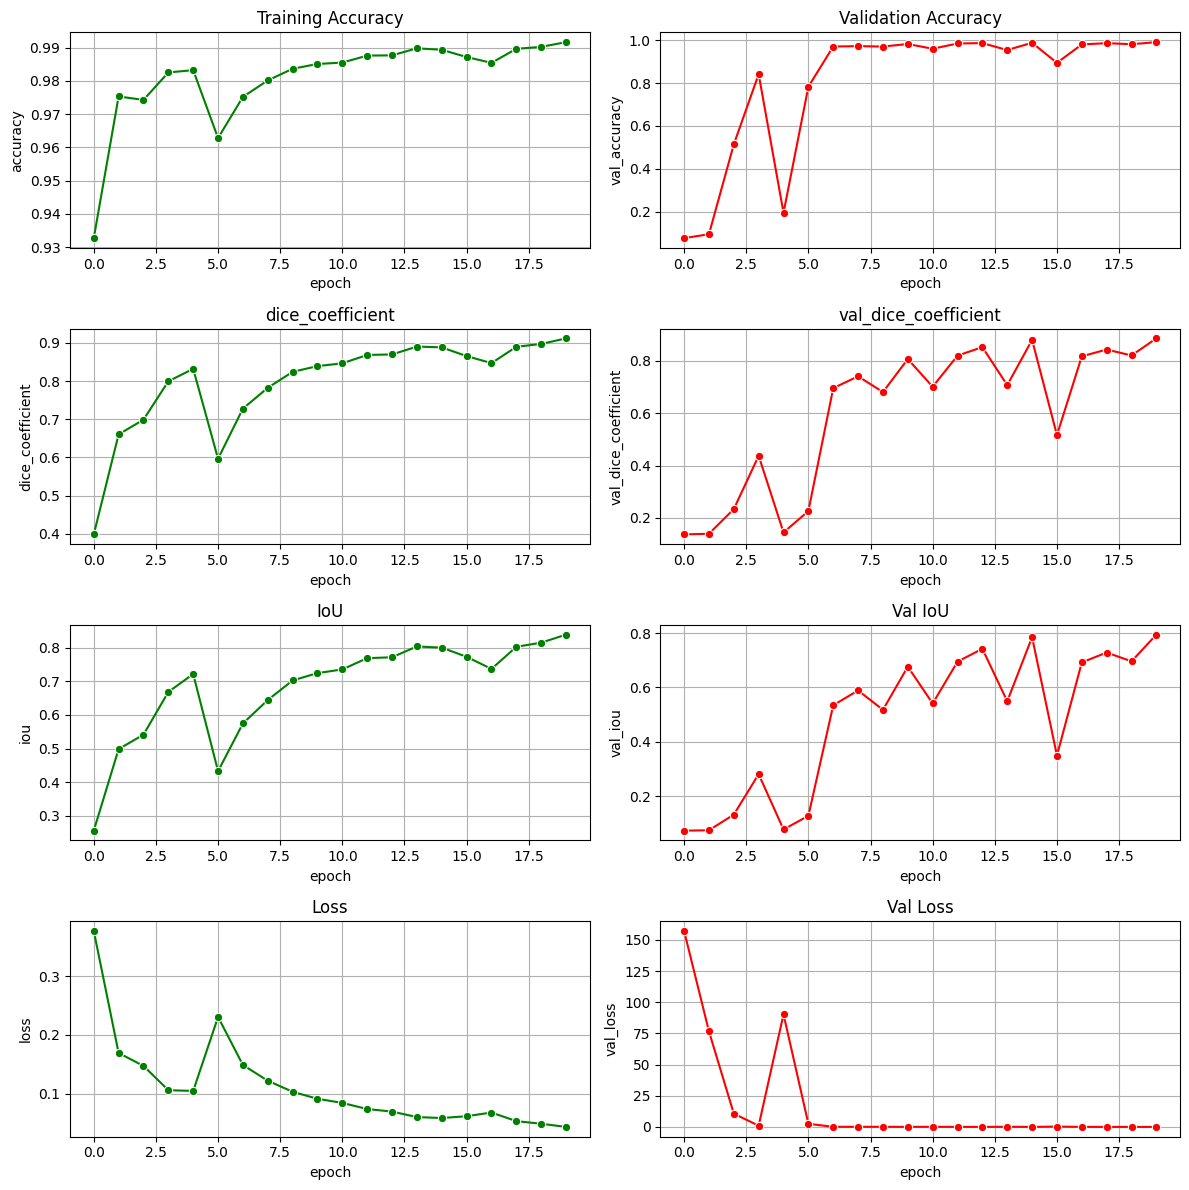

In [29]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

sns.lineplot(ax=axs[0,0], data=liver_history, x='epoch', y='accuracy', marker='o',color="green")
axs[0,0].set_title('Training Accuracy')
axs[0,0].grid(True)

sns.lineplot(ax=axs[0,1], data=liver_history, x='epoch', y='val_accuracy', marker='o', color='red')
axs[0,1].set_title('Validation Accuracy')
axs[0,1].grid(True)

sns.lineplot(ax=axs[1,0], data=liver_history, x='epoch', y='dice_coefficient', marker='o',color="green")
axs[1,0].set_title('dice_coefficient')
axs[1,0].grid(True)

sns.lineplot(ax=axs[1,1], data=liver_history, x='epoch', y='val_dice_coefficient', marker='o', color='red')
axs[1,1].set_title('val_dice_coefficient')
axs[1,1].grid(True)

sns.lineplot(ax=axs[2, 0], data=liver_history, x='epoch', y='iou', marker='o', color="green")
axs[2, 0].set_title('IoU')
axs[2, 0].grid(True)

sns.lineplot(ax=axs[2, 1], data=liver_history, x='epoch', y='val_iou', marker='o', color='red')
axs[2, 1].set_title('Val IoU')
axs[2, 1].grid(True)

sns.lineplot(ax=axs[3, 0], data=liver_history, x='epoch', y='loss', marker='o', color="green")
axs[3, 0].set_title('Loss')
axs[3, 0].grid(True)

sns.lineplot(ax=axs[3, 1], data=liver_history, x='epoch', y='val_loss', marker='o', color='red')
axs[3, 1].set_title('Val Loss')
axs[3, 1].grid(True)

plt.tight_layout()
plt.show()

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# Define the Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

# Define the Intersection over Union (IoU)
def iou(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# Now load the model
model = load_model(
    'liver_segmentation_model_final.keras',
    custom_objects={
        'dice_coefficient': dice_coefficient,
        'iou': iou
    }
)

# Optional: Check model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d_4[0][0]  

 Total params: 5,598,789 (21.36 MB)

 Trainable params: 1,865,409 (7.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

 Optimizer params: 3,730,820 (14.23 MB)